In [1]:
import pandas as pd
import numpy as np
import os
import time
import sys
import scanpy as sc
import scipy
import umap
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import gget

import celltypist
from celltypist import models

import matplotlib.pyplot as plt
import seaborn as sns

2023-09-06 10:06:17.142006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 10:06:17.256083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-06 10:06:17.256117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-06 10:06:17.282462: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-06 10:06:24.219787: W tensorflow/stream_executor/pla

In [2]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/clean_data/"

data = {}
meta = []

for f in os.listdir(dirpath):
    if "cpm" in f:
        fullpath = f"{dirpath}{f}"
        key = f.split("_cpm")[0]
        df = pd.read_parquet(fullpath)
        print(f"{key} {df.shape=}")

        # store the barcodes
        idf = pd.DataFrame(df.index.tolist(), columns=['barcode'])
        idf['key'] = key

        # rename index
        df = df.reset_index(drop=True)
        df.index = f"{key}_" + df.index.astype(str)

        # add new names
        idf['cellId'] = df.index.to_list()

        meta.append(idf)
        data[key] = df

meta = pd.concat(meta)
meta['diet'] = meta['key'].apply(lambda x: x.split("_")[0])
meta['sex'] = meta['key'].apply(lambda x: x.split("_")[1])
print(f"{meta.shape=}")
meta.head()

fed_f df.shape=(11290, 22047)
fasted_m df.shape=(10227, 22211)
fed_m df.shape=(9249, 21851)
fasted_f df.shape=(12171, 22861)
meta.shape=(42937, 5)


,barcode,key,cellId,diet,sex
0,AAACCCAAGCTAGAAT-1,fed_f,fed_f_0,fed,f
1,AAACCCAAGTACCATC-1,fed_f,fed_f_1,fed,f
2,AAACCCAAGTGCGCTC-1,fed_f,fed_f_2,fed,f
3,AAACCCACACTATGTG-1,fed_f,fed_f_3,fed,f
4,AAACCCAGTGTCCAAT-1,fed_f,fed_f_4,fed,f


In [3]:
## combine data!
df = [v for v in data.values()]

df = pd.concat(df)
print(f"{df.shape=}")
df = df.fillna(0)
df.head()

df.shape=(42937, 23366)


,Xkr4,Gm1992,Gm19938,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Gm16041,...,Fmr1nb,Gm14808,Ercc6l,Fgf16,Tbx22,Gm14936,Tcp11x2,Cldn2,Gm15298,AC168977.1
fed_f_0,1238.560425,68.808914,68.808914,0.0,0.0,0.00000,68.808914,68.808914,275.235657,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fed_f_1,969.367920,193.873581,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fed_f_2,391.006836,97.751709,0.000000,0.0,0.0,0.00000,97.751709,0.000000,195.503418,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fed_f_3,2214.676025,0.000000,147.645065,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fed_f_4,1603.175781,152.683411,25.447235,0.0,0.0,101.78894,0.000000,50.894470,76.341705,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sampling

In [4]:
# n = 20000
# sample = df.sample(n)
sample = df.copy()
sample_meta = meta[meta['cellId'].isin(sample.index.to_list())]

# sort em!
sample = sample.sort_index()
sample_meta = sample_meta.sort_values(by='cellId')

print(f"{sample.shape=}")
print(f"{sample_meta.shape=}")

print(sample.head())
print()
print(sample_meta.head())

sample.shape=(42937, 23366)
sample_meta.shape=(42937, 5)
                      Xkr4      Gm1992     Gm19938  Rp1  Sox17  Mrpl15   
fasted_f_0      395.569641    0.000000  197.784821  0.0    0.0     0.0  \
fasted_f_1      593.330994  118.666199    0.000000  0.0    0.0     0.0   
fasted_f_10    2115.541016  325.467865  325.467865  0.0    0.0     0.0   
fasted_f_100   1227.747070  613.873535    0.000000  0.0    0.0     0.0   
fasted_f_1000  1318.859619    0.000000    0.000000  0.0    0.0     0.0   

                   Lypla1       Tcea1  Rgs20  Gm16041  ...  Fmr1nb  Gm14808   
fasted_f_0       0.000000  197.784821    0.0      0.0  ...     0.0      0.0  \
fasted_f_1     118.666199    0.000000    0.0      0.0  ...     0.0      0.0   
fasted_f_10      0.000000  162.733932    0.0      0.0  ...     0.0      0.0   
fasted_f_100     0.000000  306.936768    0.0      0.0  ...     0.0      0.0   
fasted_f_1000  101.450745  101.450745    0.0      0.0  ...     0.0      0.0   

               Ercc6l  

In [5]:
# break

# PCA

X.shape=(42937, 200)


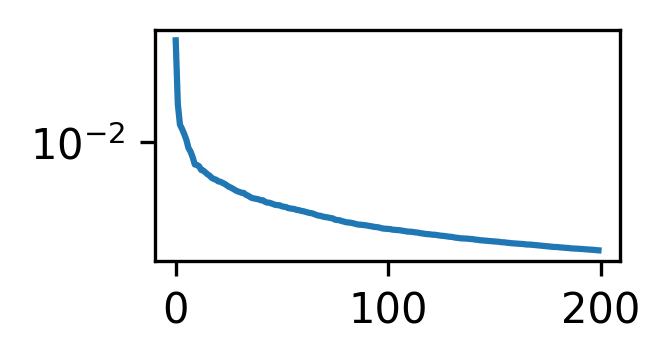

In [6]:
pca = PCA(n_components=200, svd_solver='arpack')

X = pca.fit_transform(sample.to_numpy())
print(f"{X.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 1

plt.plot(pca.explained_variance_ratio_)
plt.yscale("log")

In [7]:
# test = pd.DataFrame(X)
# test['sex'] = sample_meta['sex'].to_list()
# test['diet'] = sample_meta['diet'].to_list()
# test['key'] = sample_meta['key'].to_list()

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 3, 3

# sns.scatterplot(data=test, 
#                 x=0,
#                 y=1,
#                 s=5,
#                 hue='key',
#                 ec='none',
#                 alpha=0.6)

# plt.yscale("log")
# plt.xscale("log")

edf.shape=(42937, 2)


<AxesSubplot: xlabel='UMAP 1', ylabel='UMAP 2'>

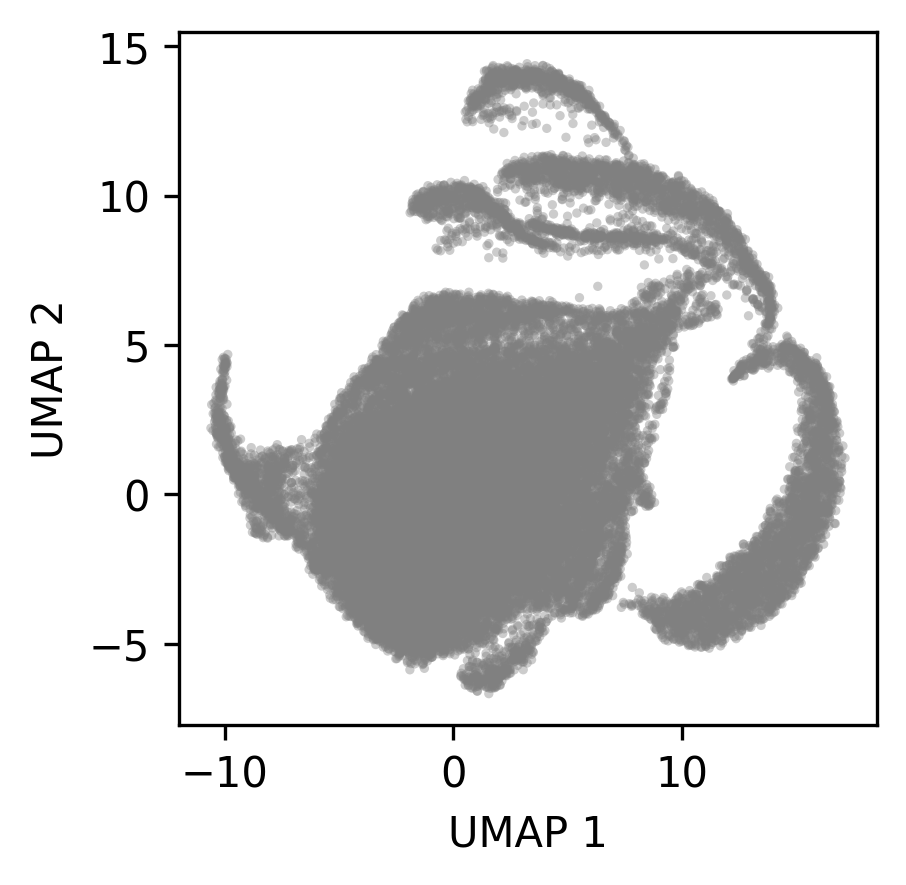

In [21]:
"""UMAP embedding for plotting """
n_neighbors = 100
min_dist = 0.8
mappy = umap.UMAP(n_components=2, 
                  n_neighbors=n_neighbors,
                  min_dist=min_dist)

edf = mappy.fit_transform(X)
edf = pd.DataFrame(edf, columns=['UMAP 1', 'UMAP 2'])
print(f"{edf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.scatterplot(data=edf, 
                x='UMAP 1',
                y='UMAP 2',
                s=5,
                c='grey',
                ec='None',
                alpha=0.4,)

# plt.gca().legend().remove()

In [ ]:
break

In [ ]:
def cluster(X, knn=11, resolution=1.0):
    """A function to cluster a data matrix """
    # transform to adjacency graph 
    nbrs = NearestNeighbors(n_neighbors=knn, algorithm='ball_tree').fit(X)
    g = nbrs.kneighbors_graph(X).toarray()
    g = sc._utils.get_igraph_from_adjacency(g, directed=False)
    
    partition_type = leidenalg.RBConfigurationVertexPartition
    part = leidenalg.find_partition(g, partition_type)
    groups = np.array(part.membership)

    return groups


""" Cluster the data: Lieden clustering"""
edf['cluster'] = cluster(X, knn=21, resolution=0.5)
edf['cluster'] = edf['cluster'].astype(float) + 1

print(edf['cluster'].value_counts(normalize=True))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(data=edf, 
                x='UMAP 1',
                y='UMAP 2',
                s=2,
                hue='cluster',
                palette='viridis',
                ec='None',
                lw=1,
                alpha=0.6)

sns.move_legend(plt.gca(), 
                loc='upper left',
                bbox_to_anchor=(1.1, 1))

In [10]:
"""SAVE SOME DATA"""

print(f"{edf.shape=}")
print(f"{sample_meta.shape=}")

edf['barcode'] = sample_meta['barcode'].to_list()
edf['key'] = sample_meta['key'].to_list()
edf['cellId'] = sample_meta['cellId'].to_list()
edf['diet'] = sample_meta['diet'].to_list()
edf['sex'] = sample_meta['sex'].to_list()

outdir = '/nfs/turbo/umms-indikar/shared/projects/MC3R/results/'
fname = f"{outdir}cluster_results.csv"

edf.to_csv(fname, index=False)

edf.head()



edf.shape=(42937, 3)
sample_meta.shape=(42937, 5)


,UMAP 1,UMAP 2,cluster,barcode,key,cellId,diet,sex
0,-0.157389,1.280468,1.0,AAACCCAGTACAGCGA-1,fasted_f,fasted_f_0,fasted,f
1,1.220655,5.268371,28.0,AAACCCAGTACCAGAG-1,fasted_f,fasted_f_1,fasted,f
2,-0.903606,3.418034,15.0,AAACGAAAGTGAGCCA-1,fasted_f,fasted_f_10,fasted,f
3,4.865648,5.663822,6.0,AAAGGTATCAGGTAAA-1,fasted_f,fasted_f_100,fasted,f
4,3.332703,5.012566,6.0,ACGATCACAGGTTCGC-1,fasted_f,fasted_f_1000,fasted,f


In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## DEG 

In [ ]:
""" perform differential expression analysis on each cluster vs. all other cells """

sample_meta['UMAP1'] = edf['UMAP 1'].to_list()
sample_meta['UMAP2'] = edf['UMAP 2'].to_list()
sample_meta['cluster'] = edf['cluster'].to_list()

# extract the genes which have at least some assigned reads
count_threshold = 5000
test_genes = (sample.sum() > count_threshold)
test_genes = test_genes.index[test_genes == True].tolist()

print(f"{len(test_genes)=}")

clusterIds = sorted(sample_meta['cluster'].unique())

res = []

for cid in clusterIds:
    # get the cellids for each cell in each cluster
    cellIds = sample_meta[sample_meta['cluster'] == cid]['cellId']

    # subset the cells
    ingroup = sample[sample.index.isin(cellIds)]
    outgroup = sample[~sample.index.isin(cellIds)]

    print(f"{ingroup.shape=} {outgroup.shape=}")

    # perform DEG on all genes for this cluster
    for g in test_genes:
        score, pval = scipy.stats.ranksums(ingroup[g], outgroup[g])
        lfc = np.log2((ingroup[g].mean() + 1) / (outgroup[g].mean() + 1))
    
        row = {
            'cluster' : cid,
            'gene' : g,
            'score': score,
            'pval' : pval,
            'lof2foldchange' : lfc
        }
        res.append(row)

res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()

In [ ]:
"""SAVE SOME RESULTS """

outdir = '/nfs/turbo/umms-indikar/shared/projects/MC3R/results/'
fname = f"{outdir}cluster_DEG_results.csv"
res.to_csv(fname, index=False)

res.head()

In [ ]:
alpha = 0.0001
n_test = 300
enrich_alpha = 0.001

enrichments = []

for cid in clusterIds:
    cres = res[res['cluster'] == cid]
    cres = cres[cres['pval'] <= alpha]
    cres = cres.sort_values(by='lof2foldchange')

    to_test = cres['gene'].head(n_test).to_list()
    time.sleep(20)
    
    edf = gget.enrichr(to_test, database='celltypes')
    edf = edf[edf['adj_p_val'] <= enrich_alpha]
    edf =  edf[['path_name','adj_p_val', 'overlapping_genes']]
    edf['cluster'] = cid

    enrichments.append(edf)
    # break

enrichments = pd.concat(enrichments)

outdir = '/nfs/turbo/umms-indikar/shared/projects/MC3R/results/'
fname = f"{outdir}cluster_enrichment_results.csv"
enrichments.to_csv(fname, index=False)

enrichments.head()

In [ ]:
# outdir = "/nfs/turbo/umms-indikar/shared/projects/MC3R/test_data/"
# fname = f"{outdir}celltype_enrichments_{len(sample_meta)}_sample.csv"
# enrichments.to_csv(fname)
# print(f'done: {fname}')


# fname = f"{outdir}DEG_{len(sample_meta)}_sample.csv"
# res.to_csv(fname)
# print(f'done: {fname}')

# fname = f"{outdir}{len(sample_meta)}_sample_metdadata.csv"
# sample_meta.to_csv(fname)
# print(f'done: {fname}')

In [ ]:
break

# Cell Typing

In [ ]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = False)

In [ ]:
model = models.Model.load(model = 'Developing_Mouse_Brain.pkl')
model.cell_types.shape

In [ ]:
""" create an andata object from clusters """
obsm = sample_meta.copy()
obsm['cluster'] = edf['color'].to_list()
obsm = obsm.set_index('cellId')

# build the annotate data object
andata = sc.AnnData(X=sample, obsm=obsm)

# log normalize for cell typist
sc.pp.normalize_total(andata, target_sum=1e4)
sc.pp.log1p(andata)

andata.raw = andata


In [ ]:
andata.X.shape

In [ ]:
predictions = celltypist.annotate(andata, 
                                  model = 'Developing_Mouse_Brain.pkl', 
                                  # over_clustering=obsm['cluster'],                                 
                                  # majority_voting = True

)

In [ ]:
predictions.predicted_labels

In [ ]:
predictions.predicted_labels['predicted_labels'].value_counts()

In [ ]:
sample_meta['pred_celltype'] = predictions.predicted_labels['predicted_labels'].to_list()


sample_meta.head()

In [ ]:
ct = "Blood: Erythrocyte"

cellIds = sample_meta[sample_meta['pred_celltype'] == ct]['cellId'].to_list()

T = sample.loc[cellIds]
T.head()

In [ ]:
## blood DEG
mask = (sample_meta['pred_celltype'] == ct)
inIds = sample_meta[mask]['cellId'].to_list()
outIds = sample_meta[~mask]['cellId'].to_list()

print(f"{len(inIds)=} {len(outIds)=}")

ingroup = sample[sample.index.isin(inIds)]
outgroup = sample[sample.index.isin(outIds)]

print(f"{ingroup.shape=} {outgroup.shape=}")

res = []

for g in sample.columns:
    score, pval = scipy.stats.ranksums(ingroup[g], outgroup[g])

    lfc = np.log2((ingroup[g].mean() + 1) / (outgroup[g].mean() + 1))

    row = {
        'gene' : g,
        'score': score,
        'pval' : pval,
        'lof2foldchange' : lfc
    }

    res.append(row)

res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()

In [ ]:
alpha = 0.001
pdf = res.copy()

pdf = pdf[pdf['pval'] <= alpha ]
pdf = pdf.sort_values(by='lof2foldchange', ascending=False)
n_genes = 1000

to_test = pdf['gene'].head(n_genes).to_list()

edf = gget.enrichr(to_test, database='celltypes')
edf[['path_name','adj_p_val', 'overlapping_genes']].head(15)


In [ ]:
?gget.enrichr